## Exercise 2: Employee Turn Over Data
### Jade Watson: 20052115

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostClassifier

## Data Exploration and Visualization

In [2]:
employeeTurnOver = pd.read_csv('Employee_turn_over_data.csv')
employeeTurnOver.shape

(14999, 10)

In [3]:
employeeTurnOver.head()

,satisfaction score,last evaluation,number project,average montly hours,time spend company,work accident,left,promotion last 5years,job role,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# Checking for Duplicates
sum(employeeTurnOver.duplicated(employeeTurnOver.columns))

3008

In [5]:
# Remove duplicates
employeeTurnOver = employeeTurnOver.drop_duplicates(employeeTurnOver.columns, keep='last')
sum(employeeTurnOver.duplicated(employeeTurnOver.columns))

0

In [6]:
employeeTurnOver.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 783 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction score     11991 non-null  float64
 1   last evaluation        11991 non-null  float64
 2   number project         11991 non-null  int64  
 3   average montly hours   11991 non-null  int64  
 4   time spend company     11991 non-null  int64  
 5   work accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion last 5years  11991 non-null  int64  
 8   job role               11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


In [7]:
employeeTurnOver.shape

(11991, 10)

There are no missing values in the data. This is evident because each column has 11991 non null values which is the size of the dataset.

In [8]:
# Transform Columns to a more appropriate data type
employeeTurnOver['job role'] = employeeTurnOver['job role'].astype('category')
employeeTurnOver['salary'] = employeeTurnOver['salary'].astype('category')

In [9]:
employeeTurnOver.describe()

,satisfaction score,last evaluation,number project,average montly hours,time spend company,work accident,left,promotion last 5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


I am interested to see if number hours per month has an affect on an employee leaving. In particular, do employees in the third quearter (75%) of hours per month leave. The hours range from 243-310 hours.

In [10]:
employeeTurnOver['left'].value_counts()

0    10000
1     1991
Name: left, dtype: int64

<AxesSubplot:xlabel='if an employee has left the company', ylabel='number of employees'>

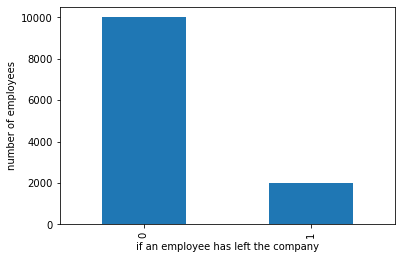

In [11]:
employeeTurnOver['left'].value_counts().plot.bar(xlabel='if an employee has left the company',ylabel='number of employees')

A zero indicates the employee currently works at the company and a one represents the employee has left the company. It is evident that 1991 employees have left. This is approximately 19% of employees. I want to investigate why the 19% of employees left. To do so, I investigate some of the other features such as salary, job role, and promotion.

<AxesSubplot:xlabel='Salary Type'>

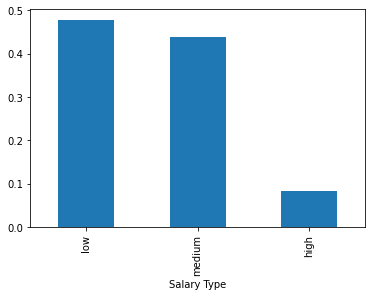

In [12]:
employeeTurnOver['salary'].value_counts(normalize=True).plot.bar(xlabel='Salary Type')

It is evident that approximately 48% of employees receive a low salary, 43% receive a medium salary, and 9% receive a high salary.

<AxesSubplot:xlabel='Job Role'>

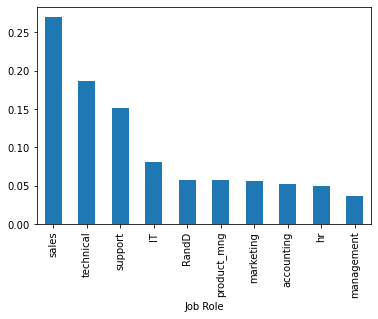

In [13]:
employeeTurnOver['job role'].value_counts(normalize=True).plot.bar(xlabel='Job Role')

Majority of the employees work in sales and the least in management. I suspect that there is a correlation between job type and salary. This will be further investigated below.

In [14]:
employeeTurnOver['promotion last 5years'].value_counts(normalize=True)

0    0.983071
1    0.016929
Name: promotion last 5years, dtype: float64

It is evident that 1.6% of people received a promotion within the last five years. This is an incredibly low rate over five years. I am curious to see if this contributions to the turnover rate of employees.

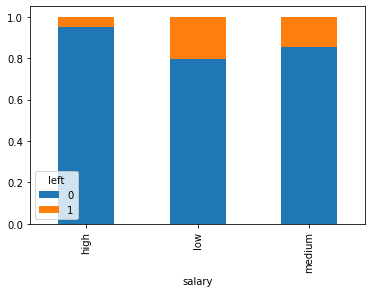

In [15]:
salary = pd.crosstab(employeeTurnOver['salary'],employeeTurnOver['left'])
salary.div(salary.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.show()

We can see that employees with a lower salary tend to leave the company more often than employees with a higher salary.

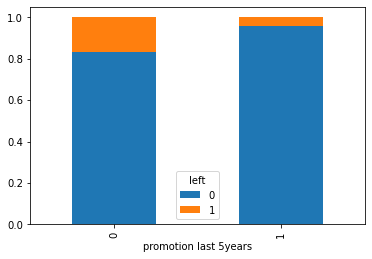

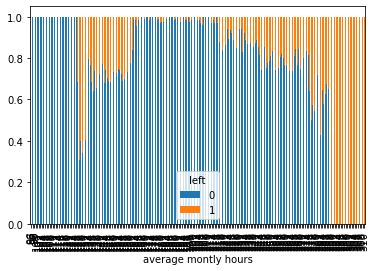

<AxesSubplot:xlabel='job role'>

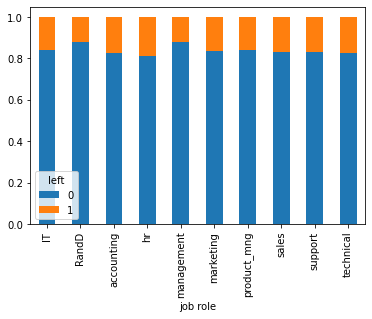

In [16]:
promotion = pd.crosstab(employeeTurnOver['promotion last 5years'],employeeTurnOver['left'])
hours = pd.crosstab(employeeTurnOver['average montly hours'],employeeTurnOver['left'])
job = pd.crosstab(employeeTurnOver['job role'],employeeTurnOver['left'])

promotion.div(promotion.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
hours.div(hours.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.show()
job.div(job.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)

There are three plots above. The first plot demonstrates that employees who do not receive a promotion within five years leave more frequently than employees who do receive a promotion within five years. The second plot is heavily populated, however, provides great insight into the general trend of employees who work over 243 hours a month tend to leave the company. This proves my intial assumption above. The third plot illustrates the job role an employee took on if they left. This plot does not provide insight as to why the employee left because the percent of employees who left are similar in each job role.

<AxesSubplot:>

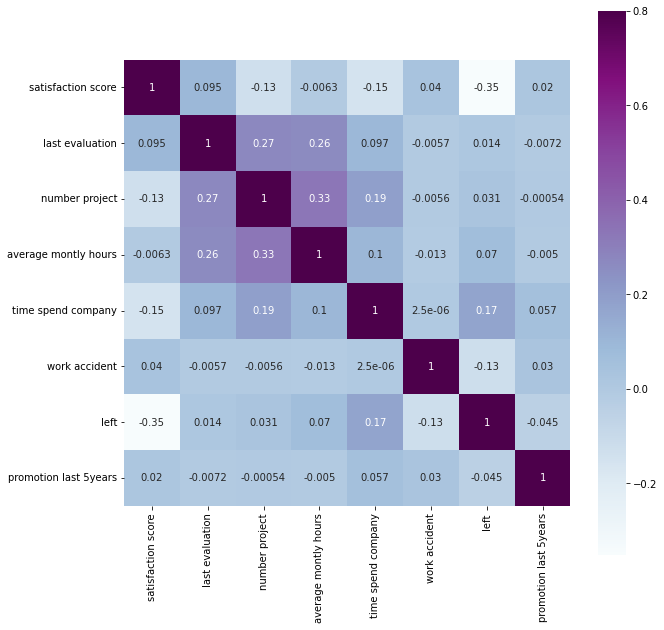

In [17]:
corr = employeeTurnOver.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,vmax=.8,square=True,cmap='BuPu',annot=True)

It is evident that the highest correlation occurs between average monthly hours and number of projects. Number of projects is also correlated with last evaluation.

## Bagging

In [18]:
employeeTurnOver = pd.get_dummies(employeeTurnOver)

In [19]:
X = employeeTurnOver.drop('left',axis=1)
y = employeeTurnOver.left

In [20]:
iteration = 1
mean = 0

kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(iteration,kf.n_splits))
    xtr,xvl, ytr, yvl = X.iloc[train_index,:],X.iloc[test_index,:], y.iloc[train_index], y.iloc[test_index]
    #ytr,yvl = y[train_index],y[test_index]
    model = DecisionTreeClassifier()
    model.fit(xtr, ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    mean += score
    print ('accuracy_score',score)
    iteration+=1
print ('\n Mean Validation Accuracy',mean/(iteration-1))


1 of kfold 10
accuracy_score 0.9716666666666667

2 of kfold 10
accuracy_score 0.97581317764804

3 of kfold 10
accuracy_score 0.9674728940783986

4 of kfold 10
accuracy_score 0.9699749791492911

5 of kfold 10
accuracy_score 0.97581317764804

6 of kfold 10
accuracy_score 0.9649708090075062

7 of kfold 10
accuracy_score 0.9591326105087573

8 of kfold 10
accuracy_score 0.9649708090075062

9 of kfold 10
accuracy_score 0.9666388657214345

10 of kfold 10
accuracy_score 0.9674728940783986

 Mean Validation Accuracy 0.9683926883514038


I decided to split my data into a test and training set after my initial boosting classification because I wanted to experiment with the tuning of the hyper-parameters on the training set. Prior to the split, I prepared the inputs such that all categorical variables, job role and salary, are transformed into dummy variables. This turns each category of the categorical variables into a new feature that indicates type using 0 and 1. This makes it easier to compare during classification.

The bagging model is setup such that the inputs X and y undergo 10 K fold cross validations. The train and test values for both X and y at index rows are obtained using the .loc function. These will then be used for fitting of the model. The bagging model I decided to use is the DecisionTreeClassifier. The model is then fitted according to the inputted X training vectors and y target values. Next, I analyze the accuracy of the model by comparing the target values with the test prediction. The results are printed above. I setup the bagging model in this way because I want to explore if tuning different hyper-parameters results in a better accuracy.

The mean validation accuracy is 0.9698. To boost the model's performance, I explore the different hyper parameters below.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Hyperparameter Tuning

In [22]:
# Create base model
model = DecisionTreeClassifier()
print(model.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


There are a few parameters we can consider exploring. These are printed above. I choose to tune the maximum depth, minimum number of leaves, and criterion.

In [23]:
parameters = {'max_depth': [2, 3, 5, 10],
              'min_samples_leaf': [5, 10, 20, 50, 100],
              'criterion': ['gini','entropy']}
model = DecisionTreeClassifier()

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

 The best score across ALL searched params:
 0.979045037531276

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}


To explore the effects of each, I set different values to each variable to be used in the model (DecisionTreeClassifier). I used GridSearchCV to generate candidates from parameter values that could possibly result in a better accuracy. The results are then fitted training dataset. I decided to run it on the training dataset to print out optimal values of parameters to be used on the test dataset.

The best accuracy obtained is 0.9764 which is worst than the accuracy without tuning the parameters. Overall, the best parameters from the defined above are a gini criterion, maximum depth of 10, and a minimum of 10 sample leaves.

## Boosting

In [24]:
iteration = 1
mean = 0

kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print('\n{} of kfold {}'.format(iteration,kf.n_splits))
    xtr,xvl, ytr, yvl = X.iloc[train_index,:],X.iloc[test_index,:], y.iloc[train_index], y.iloc[test_index]
    model = CatBoostClassifier(iterations=10)
    model.fit(xtr, ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    mean += score
    print ('accuracy_score',score)
    iteration+=1
print ('\n Mean Validation Accuracy',mean/(iteration-1))


1 of kfold 10
Learning rate set to 0.5
0:	learn: 0.2011723	total: 158ms	remaining: 1.42s
1:	learn: 0.1295626	total: 170ms	remaining: 678ms
2:	learn: 0.1090707	total: 178ms	remaining: 414ms
3:	learn: 0.0968638	total: 186ms	remaining: 279ms
4:	learn: 0.0913542	total: 194ms	remaining: 194ms
5:	learn: 0.0801056	total: 202ms	remaining: 135ms
6:	learn: 0.0777949	total: 211ms	remaining: 90.3ms
7:	learn: 0.0743679	total: 224ms	remaining: 56ms
8:	learn: 0.0693490	total: 236ms	remaining: 26.2ms
9:	learn: 0.0668821	total: 243ms	remaining: 0us
accuracy_score 0.9791666666666666

2 of kfold 10
Learning rate set to 0.5
0:	learn: 0.1937389	total: 13.3ms	remaining: 120ms
1:	learn: 0.1412360	total: 23.9ms	remaining: 95.7ms
2:	learn: 0.1089174	total: 36.1ms	remaining: 84.3ms
3:	learn: 0.0934885	total: 48.6ms	remaining: 72.8ms
4:	learn: 0.0873729	total: 58.8ms	remaining: 58.8ms
5:	learn: 0.0818365	total: 71.5ms	remaining: 47.7ms
6:	learn: 0.0786969	total: 82.5ms	remaining: 35.3ms
7:	learn: 0.0754549	tota

The preparation of the inputs was explained in the bagging model. The boosting model is setup in the exact same way such that the inputs X and y undergo 10 K fold cross validations. The train and test values for both X and y at index rows are obtained using the .loc function. These will then be used for fitting of the model. The boosting model I decided to use is the CatBoostClassifier. The model is then fitted according to the inputted X training vectors and y target values. Next, I analyze the accuracy of the model by comparing the target values with the test prediction. The results are printed above. I setup the boosting model in this way because I want to explore if tuning different hyper-parameters results in a better accuracy.

The mean validation accuracy is 0.9807. To boost the model's performance, I explore the different hyper parameters below.

### Hyperparameter Tuning

In [25]:
parameters = {'learning_rate': [0.01, 0.1, 1.0],
              'iterations': [10, 50, 100, 250],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}
model = CatBoostClassifier(iterations=10)

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

0:	learn: 0.5220315	total: 27.4ms	remaining: 6.81s
1:	learn: 0.4033230	total: 60.1ms	remaining: 7.45s
2:	learn: 0.3167118	total: 92.3ms	remaining: 7.6s
3:	learn: 0.2568938	total: 112ms	remaining: 6.91s
4:	learn: 0.2097909	total: 146ms	remaining: 7.16s
5:	learn: 0.1791175	total: 177ms	remaining: 7.21s
6:	learn: 0.1557661	total: 198ms	remaining: 6.88s
7:	learn: 0.1384734	total: 219ms	remaining: 6.61s
8:	learn: 0.1248329	total: 245ms	remaining: 6.57s
9:	learn: 0.1146095	total: 276ms	remaining: 6.63s
10:	learn: 0.1080536	total: 296ms	remaining: 6.42s
11:	learn: 0.1015186	total: 315ms	remaining: 6.24s
12:	learn: 0.0959807	total: 336ms	remaining: 6.12s
13:	learn: 0.0922060	total: 349ms	remaining: 5.89s
14:	learn: 0.0889859	total: 384ms	remaining: 6.01s
15:	learn: 0.0865785	total: 423ms	remaining: 6.18s
16:	learn: 0.0837987	total: 457ms	remaining: 6.27s
17:	learn: 0.0816200	total: 496ms	remaining: 6.39s
18:	learn: 0.0803152	total: 534ms	remaining: 6.49s
19:	learn: 0.0782824	total: 577ms	remai

There are a few boosting parameters we could consider exploring different:
- number of trees
- learning rate
- tree depth
- regularizar
- random strength
- bagging temperatures
- border count

I decided to explore: number of trees, learning rate, tree depth, and regularizar. To explore the effects of each, I set different values to each variable to be used in the model (CatBoostClassifier). I used GridSearchCV to generate candidates from parameter values that could possibly result in a better accuracy. The results are then fitted using training dataset. I decided to test it on the training dataset to print out optimal values of parameters to be used during testing. I found that increasing the number of trees resulted in a longer runtime, however, did not affect the accuracy to much and for this reason, when using the test dataset, I would keep the number of trees to the minimal value that provides the mean accuracy.

The best accuracy obtained is 0.9818 which is worst than the accuracy without tuning the parameters. I belive it is due to tuning the number of leaves for the reason I explained above. Overall, the best parameters are a tree depth of 4, 250 trees, a 3 twelve leaf regulizar, and a 0.1 learning rate.

## Summary

Throughout the process, I have been commenting on my findings and analyzed the results. In this section, I am summarizing the results and concluding which model with what parameters performs the best.

Bagging without tuning any of the parameters result in a mean accuracy 0.969. A list of the accuracy at each K fold is printed in the Bagging section. After tuning the hyper parameters to the optimal value an accuracy of 0.9764 is reached. The optimal value of each parameter is a gini criterion, maximum depth of 10, and a minimum of 10 sample leaves. Notice tuning the hyper parameters resulted in a lower performance accuracy.

Boosting with original parameters produces a mean accuracy of 0.980. After tuning the hyper parameters to the optimal value an accuracy of 0.981 is reached. The optimal value of each parameter is a tree depth of 4, 250 trees, a 3 twelve leaf regulizar, and a 0.1 learning rate.

In conclusion, the bagging model (DecisionTreeClassifier) performed better than the boosting model (CatBoostClassifier). Overall, the best model performance comes from a dfecision tree classifier with no tuning of hyper parameters.